
# ScalarField Signal Processing Tutorial

This tutorial demonstrates the new signal processing capabilities for `ScalarField`, including:
1. Generating synthetic 4D noise fields.
2. Computing Power Spectral Density (PSD) in time and space.
3. Frequency-Space Mapping (Scanning PSD along a spatial axis).
4. Cross-Correlation and Time Delay Estimation.
5. Coherence Mapping.

These tools allow for comprehensive analysis of 4D physical fields, such as those encountered in gravitational wave detectors (Environmental Monitoring).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.fields import ScalarField

# Set random seed for reproducibility
np.random.seed(42)


## 1. Data Generation

We simulate a 4D `ScalarField` representing a physical environment (e.g., magnetic field or seismic variation).
- **Signal**: A 30 Hz sine wave source located at x=1m.
- **Noise**: Gaussian background noise.
- **Propagation**: The source signal propagates outward, creating time delays at other locations.


In [2]:
# Simulation Parameters
fs = 256 * u.Hz
duration = 4 * u.s
t = np.arange(int((fs * duration).to_value(u.dimensionless_unscaled))) / fs.value

x = np.linspace(0, 5, 20)  # 5 meters, 20 points
y = np.linspace(0, 2, 5)  # 2 meters, 5 points
z = np.array([0])  # 2D plane simulation (z=0)

# Create empty 4D array: (t, x, y, z)
shape = (len(t), len(x), len(y), len(z))
data = np.random.normal(0, 0.1, size=shape)  # Background noise

# Add a propagating signal source at x=1.0m (index approx 4)
# Source: 30 Hz sine wave
source_freq = 30.0
source_signal = np.sin(2 * np.pi * source_freq * t)

# Propagate signal: delay increases with distance from source (x=1.0)
v_prop = 10.0  # Propergation velocity: 10 m/s
source_pos = 1.0

for i, xi in enumerate(x):
    dist = abs(xi - source_pos)
    delay = dist / v_prop
    shift = int(delay * fs.value)

    # Apply delayed signal (rolling)
    sig_delayed = np.roll(source_signal, shift)
    # Simple attenuation
    amp = 1.0 / (1.0 + dist)

    # Add to all y points at this x
    data[:, i, :, 0] += amp * sig_delayed[:, np.newaxis]

# Create ScalarField
field = ScalarField(
    data,
    unit=u.V,
    axis0=t * u.s,
    axis1=x * u.m,
    axis2=y * u.m,
    axis3=z * u.m,
    name="Environmental Field",
)

print(field)

ScalarField([[[[ 2.63448962e-01],
               [ 1.99951117e-01],
               [ 2.78546401e-01],
               [ 3.66080532e-01],
               [ 1.90362209e-01]],

              [[-3.88670435e-01],
               [-2.07335458e-01],
               [-2.88513266e-01],
               [-4.12204178e-01],
               [-3.11000735e-01]],

              [[-4.23335856e-01],
               [-4.23567062e-01],
               [-3.52797860e-01],
               [-5.68322111e-01],
               [-5.49485870e-01]],

              ...,

              [[-2.56689953e-01],
               [-1.14974037e-01],
               [-1.73639137e-01],
               [-2.59490269e-01],
               [-1.55187505e-01]],

              [[-1.46715260e-01],
               [-5.95585163e-02],
               [-2.26628325e-01],
               [-1.89189230e-01],
               [-1.95633831e-01]],

              [[-8.82945594e-02],
               [ 8.76689632e-02],
               [ 8.41624627e-02],
               [ 5


## 2. Power Spectral Density (PSD)

We can compute the PSD at specific points to analyze the frequency content.
The `compute_psd` (or `field.psd`) method handles Welch's method for you.


<Figure size 1000x600 with 0 Axes>

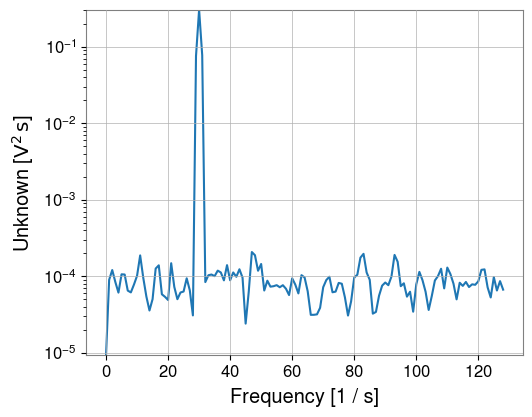

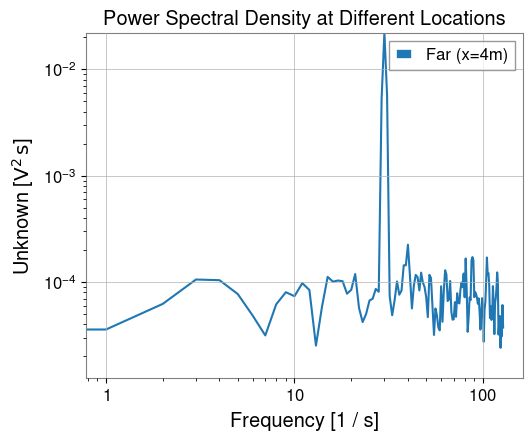

In [3]:
# Extract PSD at the source location (x=1m)
psd_source = field.psd(point_or_region=(1.0 * u.m, 0.0 * u.m, 0.0 * u.m))

# Extract PSD far from source (x=4m)
psd_far = field.psd(point_or_region=(4.0 * u.m, 0.0 * u.m, 0.0 * u.m))

# Plot
plt.figure(figsize=(10, 6))
psd_source.plot(label="Source (x=1m)")
psd_far.plot(label="Far (x=4m)")
plt.xscale("log")
plt.yscale("log")
plt.title("Power Spectral Density at Different Locations")
plt.legend()
plt.show()


## 3. Frequency-Space Map

To visualize how the spectrum changes across space, we use `freq_space_map`.
This creates a 2D map with Frequency on one axis and a Spatial coordinate (e.g., X) on the other.


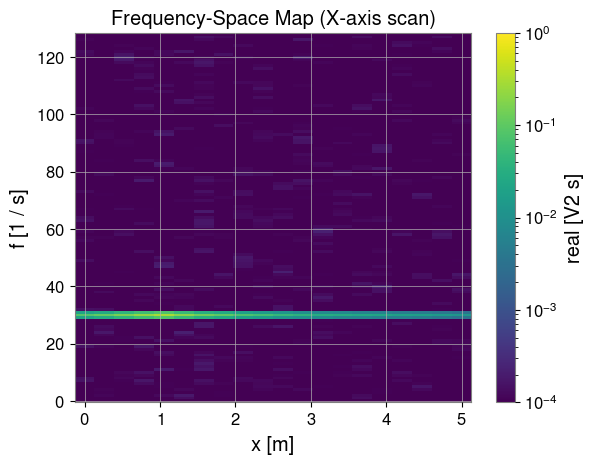

In [4]:
# Scan along X-axis, fixing Y=0, Z=0
fs_map = field.freq_space_map(axis="x", at={"y": 0 * u.m, "z": 0 * u.m})

# Plot using plot_map2d
# The map will have axes: 'f' (frequency) and 'x' (distance)
fs_map.plot_map2d(
    "fx", norm="log", title="Frequency-Space Map (X-axis scan)", vmin=1e-4, vmax=1e0
)
plt.show()


## 4. Time Delay Map

We can visualize the propagation of the signal by computing the time delay relative to the source.
`time_delay_map` computes the cross-correlation lag for every point in a plane.


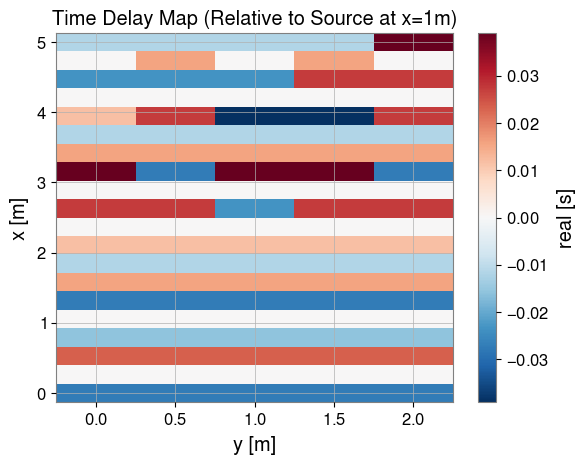

In [5]:
# Compute delay map relative to source at x=1.0m
delay_map = field.time_delay_map(
    ref_point=(1.0 * u.m, 0.0 * u.m, 0.0 * u.m),
    plane="xy",
    at={"z": 0 * u.m},
    max_lag=0.5 * u.s,  # Limit search range
)

# Plot delay map
# We expect delay to increase linearly away from x=1.0
delay_map.plot_map2d(
    "xy", title="Time Delay Map (Relative to Source at x=1m)", cmap="RdBu_r"
)
plt.show()


## 5. Coherence Map

Coherence measures the linear correlation between signals in the frequency domain.
It is useful for identifying regions that are coherent with a noise source.


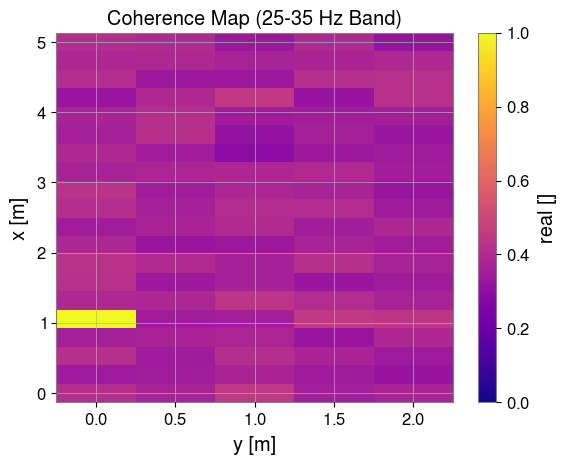

In [6]:
# Compute Coherence Map relative to source, averaging over 25-35 Hz band
coh_map = field.coherence_map(
    ref_point=(1.0 * u.m, 0.0 * u.m, 0.0 * u.m),
    plane="xy",
    at={"z": 0 * u.m},
    band=(25 * u.Hz, 35 * u.Hz),  # Focus on the signal frequency
)

coh_map.plot_map2d(
    "xy", title="Coherence Map (25-35 Hz Band)", vmin=0, vmax=1, cmap="plasma"
)
plt.show()